<a href="https://colab.research.google.com/github/lfernande3/sleepbasedlowlatencyaccess-m2m/blob/main/fyp_simpy_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simulator Overview
This notebook holds a readable SimPy skeleton for sleep-based low-latency access experiments. Each section below introduces one component (config, channel, node logic, utilities, demo) so you can present or tweak them live.


### Package Installation
Run the cell below to install required packages (matplotlib, numpy, simpy) if they're not already available in your environment.


In [3]:
# Install required packages (run this cell first if packages are missing)
%pip install -q matplotlib numpy simpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import math
import random
from collections import defaultdict, deque
from dataclasses import dataclass, field
from typing import Deque, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import simpy



### Global Configuration
`SimulationConfig` stores all knobs you might tweak during the live demo (traffic, timers, power model, run length) in one place.


In [6]:
@dataclass
class SimulationConfig:
    """Global parameters shared by every MTD in the simulation."""

    num_nodes: int = 500
    lambda_arrival: float = 1e-3  # Poisson arrival rate per slot
    q_tx: float = 0.05            # Slotted-Aloha transmit probability
    idle_timer_slots: int = 15    # t_s in slides
    wake_time_slots: int = 5      # t_w in slides
    slot_duration_ms: float = 1.0
    max_slots: int = 50000
    initial_energy_mj: float = 10000.0
    power_profile_mw: Dict[str, float] = field(
        default_factory=lambda: {
            "ACTIVE": 180.0,
            "IDLE": 8.0,
            "SLEEP": 0.02,
            "WAKEUP": 40.0,
            "DEAD": 0.0,
        }
    )

    @property
    def slot_duration_s(self) -> float:
        return self.slot_duration_ms / 1000.0


### Slotted Channel
`SlottedChannel` aggregates transmission attempts and enforces the simple collision model used in the slides.


In [7]:
class SlottedChannel:
    """Collects all transmission attempts within a slot and resolves collisions."""

    def __init__(self, env: simpy.Environment):
        self.env = env
        self.pending_txs: Dict[int, List["MTD"]] = defaultdict(list)
        self.stats = {"slots": 0, "successes": 0, "collisions": 0}
        self.action = env.process(self._run())

    def request_tx(self, node: "MTD", slot_index: int) -> None:
        if node not in self.pending_txs[slot_index]:
            self.pending_txs[slot_index].append(node)

    def _run(self):
        # Resolve slots at the end of each slot period
        while True:
            yield self.env.timeout(1)
            # At time t, we just finished slot (t-1), resolve it
            slot_index = int(self.env.now) - 1
            if slot_index >= 0:
                self._resolve_slot(slot_index)

    def _resolve_slot(self, slot_index: int) -> None:
        contenders = self.pending_txs.pop(slot_index, [])
        # Track the highest slot we've processed (slots are 0-indexed)
        self.stats["slots"] = max(self.stats["slots"], slot_index + 1)
        slot_start = float(slot_index)
        if not contenders:
            # Empty slot - no transmission attempts
            return
        if len(contenders) == 1:
            # Successful transmission
            self.stats["successes"] += 1
            contenders[0].on_tx_result(success=True, slot_start=slot_start)
            return
        # Collision - multiple nodes tried to transmit
        self.stats["collisions"] += 1
        for node in contenders:
            node.on_tx_result(success=False, slot_start=slot_start)


### Machine-Type Device State Machine
`MTD` is the core node logic: it tracks arrivals, state transitions (ACTIVE/IDLE/SLEEP/WAKEUP), and energy consumption per slot.


In [8]:
class MTD:
    """Machine-Type Device with ACTIVE/IDLE/SLEEP/WAKEUP states."""

    def __init__(self, env: simpy.Environment, node_id: int, channel: SlottedChannel, config: SimulationConfig):
        self.env = env
        self.id = node_id
        self.channel = channel
        self.config = config
        self.lambda_arrival = config.lambda_arrival
        self.q_tx = config.q_tx

        self.state = "ACTIVE"
        self.packet_queue: Deque[float] = deque()
        self.idle_slots_left = config.idle_timer_slots
        self.wakeup_slots_left = 0
        self.energy_mj = config.initial_energy_mj
        self.initial_energy_mj = config.initial_energy_mj
        self.delay_samples: List[float] = []

        self.stats = {
            "tx_attempts": 0,
            "tx_success": 0,
            "tx_collisions": 0,
            "death_slot": None,
        }

        self.action = env.process(self.run())
        self.arrivals = env.process(self.generate_packets()) if self.lambda_arrival > 0 else None

    def generate_packets(self):
        if self.lambda_arrival <= 0:
            return
        while True:
            if self.state == "DEAD":
                return
            inter_arrival = random.expovariate(self.lambda_arrival)
            yield self.env.timeout(inter_arrival)
            if self.state == "DEAD":
                return
            self.packet_queue.append(self.env.now)
            if self.state == "SLEEP":
                self.state = "WAKEUP"
                self.wakeup_slots_left = self.config.wake_time_slots
            elif self.state == "IDLE":
                self.state = "ACTIVE"
                self.idle_slots_left = self.config.idle_timer_slots

    def run(self):
        # Process each slot: at time t, we're in slot t
        while True:
            if self.state == "DEAD":
                return
            # Get current slot index (at time t, we're processing slot t)
            slot_index = int(self.env.now)
            self._handle_slot(slot_index)
            # Wait until next slot
            yield self.env.timeout(1)

    def _handle_slot(self, slot_index: int) -> None:
        self._consume_energy(slot_index)
        if self.state == "DEAD":
            return

        if self.state == "WAKEUP":
            self.wakeup_slots_left -= 1
            if self.wakeup_slots_left <= 0:
                self.state = "ACTIVE"
            return

        if self.state == "SLEEP":
            return

        if not self.packet_queue:
            if self.state == "ACTIVE":
                self.state = "IDLE"
                self.idle_slots_left = self.config.idle_timer_slots
            elif self.state == "IDLE":
                self.idle_slots_left -= 1
                if self.idle_slots_left <= 0:
                    self.state = "SLEEP"
            return

        self.state = "ACTIVE"
        self.idle_slots_left = self.config.idle_timer_slots
        if random.random() < self.q_tx:
            self.stats["tx_attempts"] += 1
            self.channel.request_tx(self, slot_index)

    def _consume_energy(self, slot_index: int) -> None:
        power_mw = self.config.power_profile_mw.get(self.state, 0.0)
        self.energy_mj -= power_mw * self.config.slot_duration_s
        if self.energy_mj <= 0 and self.state != "DEAD":
            self.energy_mj = 0.0
            self.state = "DEAD"
            self.stats["death_slot"] = slot_index

    def on_tx_result(self, success: bool, slot_start: float) -> None:
        if success:
            if self.packet_queue:
                arrival_time = self.packet_queue.popleft()
                completion_time = slot_start + 1.0
                delay_slots = completion_time - arrival_time
                if delay_slots >= 0:  # Sanity check
                    self.delay_samples.append(delay_slots)
                self.stats["tx_success"] += 1
            # If queue is empty but we got success, it's a race condition - ignore it
            return
        # Collision occurred
        self.stats["tx_collisions"] += 1

    @property
    def mean_delay_ms(self) -> float:
        if not self.delay_samples:
            return 0.0
        avg_slots = sum(self.delay_samples) / len(self.delay_samples)
        return avg_slots * self.config.slot_duration_ms

    def estimate_lifetime_years(self, elapsed_slots: int) -> float:
        elapsed_seconds = elapsed_slots * self.config.slot_duration_s
        if elapsed_seconds <= 0:
            return math.inf
        energy_drawn = self.initial_energy_mj - self.energy_mj
        if energy_drawn <= 0:
            return math.inf
        avg_power_mw = energy_drawn / elapsed_seconds
        if avg_power_mw <= 0:
            return math.inf
        lifetime_seconds = self.initial_energy_mj / avg_power_mw
        return lifetime_seconds / (3600 * 24 * 365)


### Metrics & Plotting Utilities
Helpers that aggregate per-node stats, run the environment, and produce the delay–lifetime plot you promised in the slides.


In [9]:
def summarize(nodes: List[MTD], channel: SlottedChannel, config: SimulationConfig):
    node_metrics = []
    for node in nodes:
        node_metrics.append(
            {
                "id": node.id,
                "state": node.state,
                "queue_len": len(node.packet_queue),
                "tx_success": node.stats["tx_success"],
                "tx_attempts": node.stats["tx_attempts"],
                "tx_collisions": node.stats["tx_collisions"],
                "mean_delay_ms": node.mean_delay_ms,
                "estimated_lifetime_years": node.estimate_lifetime_years(config.max_slots),
                "residual_energy_mj": node.energy_mj,
            }
        )

    delays = [m["mean_delay_ms"] for m in node_metrics if m["mean_delay_ms"] > 0]
    lifetimes = [m["estimated_lifetime_years"] for m in node_metrics if math.isfinite(m["estimated_lifetime_years"])]
    summary = {
        "mean_delay_ms": float(np.mean(delays)) if delays else 0.0,
        "median_delay_ms": float(np.median(delays)) if delays else 0.0,
        "median_lifetime_years": float(np.median(lifetimes)) if lifetimes else math.inf,
        "throughput_packets_per_slot": (
            channel.stats["successes"] / channel.stats["slots"] if channel.stats["slots"] else 0.0
        ),
    }

    return {
        "config": config,
        "channel": channel.stats,
        "node_metrics": node_metrics,
        "summary": summary,
    }


def run_simulation(config: SimulationConfig, seed: int = 2024):
    random.seed(seed)
    env = simpy.Environment()
    channel = SlottedChannel(env)
    nodes = [MTD(env, node_id=i, channel=channel, config=config) for i in range(config.num_nodes)]
    env.run(until=config.max_slots)
    return summarize(nodes, channel, config)


def plot_delay_lifetime(results, max_points: int = 400):
    node_metrics = results["node_metrics"]
    samples = [m for m in node_metrics if m["mean_delay_ms"] > 0 and math.isfinite(m["estimated_lifetime_years"])]
    if len(samples) > max_points:
        random.shuffle(samples)
        samples = samples[:max_points]
    if not samples:
        print("No completed packets yet -> nothing to plot.")
        return
    x = [m["estimated_lifetime_years"] for m in samples]
    y = [m["mean_delay_ms"] for m in samples]
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, s=12, alpha=0.7)
    plt.xlabel("Estimated lifetime (years)")
    plt.ylabel("Mean delay per node (ms)")
    plt.title("Delay vs lifetime trade-off")
    plt.grid(True, alpha=0.3)
    plt.show()


### Lightweight Demo Run


=== Summary ===
Slots simulated: 19999, successes: 14, collisions: 19975
Mean delay: 14.23 ms | Median lifetime: 0.00 years | Throughput: 0.0007 pkt/slot


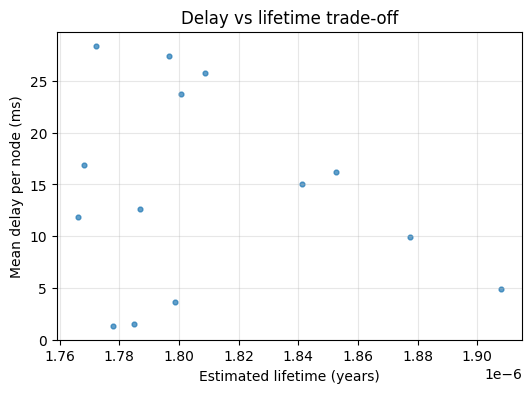

In [10]:
demo_cfg = SimulationConfig(
    num_nodes=1000,
    lambda_arrival=2e-3,
    q_tx=0.05,
    idle_timer_slots=20,
    wake_time_slots=5,
    slot_duration_ms=1.0,
    max_slots=20000,
)

results = run_simulation(demo_cfg, seed=2025)
print("=== Summary ===")
print(
    f"Slots simulated: {results['channel']['slots']}, successes: {results['channel']['successes']}, "
    f"collisions: {results['channel']['collisions']}"
)
print(
    f"Mean delay: {results['summary']['mean_delay_ms']:.2f} ms | "
    f"Median lifetime: {results['summary']['median_lifetime_years']:.2f} years | "
    f"Throughput: {results['summary']['throughput_packets_per_slot']:.4f} pkt/slot"
)
plot_delay_lifetime(results)
